In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import requests
import json
import re
import geopy.geocoders as gc
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [19]:
decisions_data = pd.read_csv("data/Filtered_ZBA_decisions.csv")
meetings_data = pd.read_csv("data/Filtered_ZBA_meetings.csv")
decisions_data

,Source,Case Number,Applicant Address,Decision (Approve/Reject)
0,ZBA Decision 2017,BOA-639633,"105 Allston Street, Ward 21",Approved
1,ZBA Decision 2017,BOA-652473,"65 Ashland Street, Ward 16",Approved
2,ZBA Decision 2017,BOA-640152,"29 Batchelder Street, Ward 8",Approved
3,ZBA Decision 2017,BOA-640141,"21-27 Batchelder Street, Ward 8",Approved
4,ZBA Decision 2017,BOA-568164,"474 Beacon Street, Ward 5",Approved
...,...,...,...,...
2916,ZBA Decision 2019,BOA-892970,"91A Baker Street, Ward 20",Denied
2917,ZBA Decision 2019,BOA-822030,"212 Chelsea Street, Ward 1",Denied
2918,ZBA Decision 2019,BOA-864614,"118-120 Granite Avenue, Ward 16",Denied
2919,ZBA Decision 2019,BOA-865287,"54 High Street, Ward 2",Denied


In [20]:
meetings_data

,Source,Case Number,Applicant,Applicant Address
0,ZBA Meeting 2018,BOA-379892,Michael Cronin,42 Thompson Street Ward 18
1,ZBA Meeting 2018,BOA-645234,Andrew Kara,45-55 Brighton Avenue Ward 21
2,ZBA Meeting 2018,BOA-645231,Andrew Kara,75 Gardner Street Ward 21
3,ZBA Meeting 2018,BOA-382897,Ruth Silman,104 Canal Street Ward 3
4,ZBA Meeting 2018,BOA-694026,Richard Lynds,77-85 Liverpool Street Ward 1
...,...,...,...,...
2998,ZBA Meeting 2017,BOA719303,James Christopher,"435 Hyde Park AV, Ward - 19"
2999,ZBA Meeting 2017,BOA730816,Elba Rojas,"82 Cummins HW, Ward - 19"
3000,ZBA Meeting 2017,BOA730716,John Harrington,"177 Glenellen Rd, Ward - 20"
3001,ZBA Meeting 2017,BOA732458,Patrick Mahoney,"118 - 122 Tremont St, Ward - 22"


In [21]:
decisions_data['Case Number'] = decisions_data.apply(lambda row: re.sub("[^0-9]", "", row['Case Number']), axis=1)
decisions_data

,Source,Case Number,Applicant Address,Decision (Approve/Reject)
0,ZBA Decision 2017,639633,"105 Allston Street, Ward 21",Approved
1,ZBA Decision 2017,652473,"65 Ashland Street, Ward 16",Approved
2,ZBA Decision 2017,640152,"29 Batchelder Street, Ward 8",Approved
3,ZBA Decision 2017,640141,"21-27 Batchelder Street, Ward 8",Approved
4,ZBA Decision 2017,568164,"474 Beacon Street, Ward 5",Approved
...,...,...,...,...
2916,ZBA Decision 2019,892970,"91A Baker Street, Ward 20",Denied
2917,ZBA Decision 2019,822030,"212 Chelsea Street, Ward 1",Denied
2918,ZBA Decision 2019,864614,"118-120 Granite Avenue, Ward 16",Denied
2919,ZBA Decision 2019,865287,"54 High Street, Ward 2",Denied


In [22]:
meetings_data = meetings_data[meetings_data['Case Number'].notna()]
meetings_data['Case Number'] = meetings_data.apply(lambda row: re.sub("[^0-9]", "", row['Case Number']), axis=1)
meetings_data

,Source,Case Number,Applicant,Applicant Address
0,ZBA Meeting 2018,379892,Michael Cronin,42 Thompson Street Ward 18
1,ZBA Meeting 2018,645234,Andrew Kara,45-55 Brighton Avenue Ward 21
2,ZBA Meeting 2018,645231,Andrew Kara,75 Gardner Street Ward 21
3,ZBA Meeting 2018,382897,Ruth Silman,104 Canal Street Ward 3
4,ZBA Meeting 2018,694026,Richard Lynds,77-85 Liverpool Street Ward 1
...,...,...,...,...
2998,ZBA Meeting 2017,719303,James Christopher,"435 Hyde Park AV, Ward - 19"
2999,ZBA Meeting 2017,730816,Elba Rojas,"82 Cummins HW, Ward - 19"
3000,ZBA Meeting 2017,730716,John Harrington,"177 Glenellen Rd, Ward - 20"
3001,ZBA Meeting 2017,732458,Patrick Mahoney,"118 - 122 Tremont St, Ward - 22"


In [23]:
meetings_with_decisions = pd.merge(meetings_data, decisions_data, left_on="Case Number", right_on="Case Number")
meetings_with_decisions = meetings_with_decisions.drop(columns=['Applicant Address_x', 'Source_x', 'Source_y'])
meetings_with_decisions = meetings_with_decisions.rename(columns={'Applicant Address_y': 'Address'})
meetings_with_decisions

,Case Number,Applicant,Address,Decision (Approve/Reject)
0,645234,Andrew Kara,"45-55 Brighton Avenue, Ward 21",Approved
1,694026,Richard Lynds,"86-86A Chestnut Street, Ward 41",Approved
2,896003,Andreas Hwang,"211 West Springfield Street, Ward 4",Approved
3,897604,Adam Grassi Article(s),"16 Marlborough Street, Ward 5",Approved
4,818377,Michael P. Ross,"111 Terrace Street, Ward 10",Approved
...,...,...,...,...
2423,733438,Joe Grealish,"26 Browning Avenue, Ward 14",Approved
2424,733442,Joe Grealish,"24 Browning Avenue, Ward 14",Approved
2425,719303,James Christopher,"435 Hyde Park Avenue, Ward 19",Denied
2426,730816,Elba Rojas,"82 Cummins Highway, Ward 19",Approved


Now to format the addresses to have "Boston, MA" in them so geopy knows whats up

In [24]:
def formatAddress(row):
    addr = row['Address']
    addr = addr.split(",")
    return addr[0].strip() + ", Boston, MA"

In [25]:
meetings_with_decisions['Address'] = meetings_with_decisions.progress_apply(formatAddress, axis=1)

100%|██████████| 2428/2428 [00:00<00:00, 127768.27it/s]


In [26]:
gc.options.default_timeout = 10
geolocator = gc.Nominatim(user_agent="Baystate_Banner_Boston_Building_Binvestigators")
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.05)
location = geolocator.geocode("175 5th Avenue NYC")
location.latitude

43.3545384

In [27]:
# meetings_with_decisions = meetings_with_decisions[:400]
meetings_with_decisions['geocodes'] = meetings_with_decisions['Address'].progress_apply(geolocator.geocode)
meetings_with_decisions

100%|██████████| 2428/2428 [20:13<00:00,  2.00it/s]


,Case Number,Applicant,Address,Decision (Approve/Reject),geocodes
0,645234,Andrew Kara,"45-55 Brighton Avenue, Boston, MA",Approved,"(45, Brighton Avenue, North Brighton, Allston,..."
1,694026,Richard Lynds,"86-86A Chestnut Street, Boston, MA",Approved,"(86, Chestnut Street, Charles River Square, Be..."
2,896003,Andreas Hwang,"211 West Springfield Street, Boston, MA",Approved,"(211, West Springfield Street, South End, Bost..."
3,897604,Adam Grassi Article(s),"16 Marlborough Street, Boston, MA",Approved,"(16, Marlborough Street, Beacon Hill, Boston, ..."
4,818377,Michael P. Ross,"111 Terrace Street, Boston, MA",Approved,"(111, Terrace Street, Roxbury Crossing, Roxbur..."
...,...,...,...,...,...
2423,733438,Joe Grealish,"26 Browning Avenue, Boston, MA",Approved,"(26, Browning Avenue, Dorchester Center, Dorch..."
2424,733442,Joe Grealish,"24 Browning Avenue, Boston, MA",Approved,"(24, Browning Avenue, Dorchester Center, Dorch..."
2425,719303,James Christopher,"435 Hyde Park Avenue, Boston, MA",Denied,"(435, Hyde Park Avenue, Mount Hope, Jamaica Pl..."
2426,730816,Elba Rojas,"82 Cummins Highway, Boston, MA",Approved,"(82, Cummins Highway, Mount Hope, West Roxbury..."


In [29]:
filtered_meetings_with_decisions = meetings_with_decisions[meetings_with_decisions['geocodes'].notna()]
filtered_meetings_with_decisions

,Case Number,Applicant,Address,Decision (Approve/Reject),geocodes
0,645234,Andrew Kara,"45-55 Brighton Avenue, Boston, MA",Approved,"(45, Brighton Avenue, North Brighton, Allston,..."
1,694026,Richard Lynds,"86-86A Chestnut Street, Boston, MA",Approved,"(86, Chestnut Street, Charles River Square, Be..."
2,896003,Andreas Hwang,"211 West Springfield Street, Boston, MA",Approved,"(211, West Springfield Street, South End, Bost..."
3,897604,Adam Grassi Article(s),"16 Marlborough Street, Boston, MA",Approved,"(16, Marlborough Street, Beacon Hill, Boston, ..."
4,818377,Michael P. Ross,"111 Terrace Street, Boston, MA",Approved,"(111, Terrace Street, Roxbury Crossing, Roxbur..."
...,...,...,...,...,...
2423,733438,Joe Grealish,"26 Browning Avenue, Boston, MA",Approved,"(26, Browning Avenue, Dorchester Center, Dorch..."
2424,733442,Joe Grealish,"24 Browning Avenue, Boston, MA",Approved,"(24, Browning Avenue, Dorchester Center, Dorch..."
2425,719303,James Christopher,"435 Hyde Park Avenue, Boston, MA",Denied,"(435, Hyde Park Avenue, Mount Hope, Jamaica Pl..."
2426,730816,Elba Rojas,"82 Cummins Highway, Boston, MA",Approved,"(82, Cummins Highway, Mount Hope, West Roxbury..."


In [30]:
filtered_meetings_with_decisions['lat'] = filtered_meetings_with_decisions.progress_apply(lambda row: row['geocodes'].latitude, axis=1)
filtered_meetings_with_decisions['long'] = filtered_meetings_with_decisions.progress_apply(lambda row: row['geocodes'].longitude, axis=1)
filtered_meetings_with_decisions

100%|██████████| 2294/2294 [00:00<00:00, 127423.30it/s]


,Case Number,Applicant,Address,Decision (Approve/Reject),geocodes,lat,long
0,645234,Andrew Kara,"45-55 Brighton Avenue, Boston, MA",Approved,"(45, Brighton Avenue, North Brighton, Allston,...",42.352638,-71.127925
1,694026,Richard Lynds,"86-86A Chestnut Street, Boston, MA",Approved,"(86, Chestnut Street, Charles River Square, Be...",42.356814,-71.070403
2,896003,Andreas Hwang,"211 West Springfield Street, Boston, MA",Approved,"(211, West Springfield Street, South End, Bost...",42.340601,-71.080255
3,897604,Adam Grassi Article(s),"16 Marlborough Street, Boston, MA",Approved,"(16, Marlborough Street, Beacon Hill, Boston, ...",42.354117,-71.073188
4,818377,Michael P. Ross,"111 Terrace Street, Boston, MA",Approved,"(111, Terrace Street, Roxbury Crossing, Roxbur...",42.328381,-71.098351
...,...,...,...,...,...,...,...
2423,733438,Joe Grealish,"26 Browning Avenue, Boston, MA",Approved,"(26, Browning Avenue, Dorchester Center, Dorch...",42.294208,-71.081057
2424,733442,Joe Grealish,"24 Browning Avenue, Boston, MA",Approved,"(24, Browning Avenue, Dorchester Center, Dorch...",42.294217,-71.081001
2425,719303,James Christopher,"435 Hyde Park Avenue, Boston, MA",Denied,"(435, Hyde Park Avenue, Mount Hope, Jamaica Pl...",42.285702,-71.118902
2426,730816,Elba Rojas,"82 Cummins Highway, Boston, MA",Approved,"(82, Cummins Highway, Mount Hope, West Roxbury...",42.284700,-71.125087


In [31]:
sub_neigh = pd.read_csv("data/Sub-Neighborhoods.csv")
sub_neigh['Census Tract#'] = sub_neigh.progress_apply(lambda row: float(row['Census Tract#']), axis=1)
sub_neigh['White Proportion'] = sub_neigh.progress_apply(lambda row: float(row['White Proportion'][:-1]), axis=1)
sub_neigh

100%|██████████| 181/181 [00:00<00:00, 90506.56it/s]


,Census Tract#,Zipcode,Neighborhood,US Geonames Sub-neigborhood,Total Population,Black,Black Proportion,White,White Proportion,American Indian & Alaska Native,...,Male,Male Proportion,Female,Female Proportion,Lat,Long,Primary Sub-Neighborhood,Secondary Sub-Neighborhood,Teritriary Sub-Neighborhood(s),T-Stop/Commuter Rail
0,1.00,"02134, 02135",Brighton,NaN,"5,324",311,5.84%,"3,315",62.27,0,...,"2,578",48.42%,"2,746",51.58%,42.361484,-71.138588,Lower Allston,Allston,Packard's Corner,Boston Landing
1,2.01,02135,Brighton,NaN,"3,991",237,5.94%,"3,164",79.28,17,...,"1,800",45.10%,"2,191",54.90%,42.354066,-71.161168,Oak Square,Brighton,Hunnewell Hill,NaN
2,2.02,02135,Brighton,NaN,"4,272",263,6.16%,"3,031",70.95,0,...,"2,175",50.91%,"2,097",49.09%,42.352605,-71.154344,Oak Square,Brighton,Allston,NaN
3,3.01,02135,Brighton,NaN,"2,946",216,7.33%,"2,203",74.78,0,...,"1,650",56.01%,"1,296",43.99%,42.354144,-71.168827,Hunnwell Hill,Oak Square,NaN,NaN
4,3.02,02135,Brighton,NaN,"3,469",359,10.35%,"2,346",67.63,25,...,"1,733",49.96%,"1,736",50.04%,42.347258,-71.167686,Brighton,St. Elizabeth's,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,9815.02,02151,East Boston,NaN,0,0,0.00%,0,0.00,0,...,0,0.00%,0,0.00%,42.396367,-71.004379,Beachmont,Orient Heights,NaN,Beachmont
177,9816.00,02128,East Boston,NaN,0,0,0.00%,0,0.00,0,...,0,0.00%,0,0.00%,42.388621,-70.993442,Orient Heights,Beachmont,NaN,Suffolk Downs
178,9817.00,02116,Beacon Hill,NaN,0,0,0.00%,0,0.00,0,...,0,0.00%,0,0.00%,42.355087,-71.065743,Downtown Crossing,NaN,NaN,Boylston Street
179,9818.00,"02130, 02215",Jamaica Plain,NaN,26,9,34.62%,17,65.38,0,...,4,15.38%,22,84.62%,42.323121,-71.116882,High Street Hill,NaN,NaN,Heath Street / Back of the Hill


In [32]:
# Function to convert the Lat and Long into a census tract.
# Refer to https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html for the FIPS code to census tract conversion
# FCC Census block conversion API link: https://geo.fcc.gov/api/census/#!/block/get_block_find

def Coord_to_census_tract(Lat,Long):
    Converter = requests.get("https://geo.fcc.gov/api/census/block/find?latitude=%20" + str(Lat) + "&longitude=" + str(Long) + "&showall=true&format=json")
    #print(Converter.text)
    Census_data = Converter.text
    json_data = json.loads(Census_data)
    # print(json_data)
    FIPS_code = json_data['Block']['FIPS']
    if FIPS_code is None:
        return "nan"
    Census_tract = FIPS_code[5:11]
    #print(type(Census_tract))
    if Census_tract[0] == "0":
        Census_tract.replace(Census_tract[0],'')
        Census_split = Census_tract[ : 4] + '.'+ Census_tract[4 : ]
        return(Census_split)
    else:
        Census_split = Census_tract[ : 4] + '.'+ Census_tract[4 : ]
        return(Census_split)

In [33]:
filtered_meetings_with_decisions['Cencus Tract'] = filtered_meetings_with_decisions.progress_apply(lambda row: float(Coord_to_census_tract(row.lat, row.long)), axis=1)
filtered_meetings_with_decisions = filtered_meetings_with_decisions[filtered_meetings_with_decisions['Cencus Tract'].notna()]
decisions_with_demos = pd.merge(filtered_meetings_with_decisions, sub_neigh, left_on="Cencus Tract", right_on="Census Tract#")
decisions_with_demos

100%|██████████| 2294/2294 [04:38<00:00,  8.24it/s]


,Case Number,Applicant,Address,Decision (Approve/Reject),geocodes,lat,long,Cencus Tract,Census Tract#,Zipcode,...,Male,Male Proportion,Female,Female Proportion,Lat,Long,Primary Sub-Neighborhood,Secondary Sub-Neighborhood,Teritriary Sub-Neighborhood(s),T-Stop/Commuter Rail
0,645234,Andrew Kara,"45-55 Brighton Avenue, Boston, MA",Approved,"(45, Brighton Avenue, North Brighton, Allston,...",42.352638,-71.127925,8.02,8.02,"02134, 02215",...,"3,551",53.33%,"3,107",46.67%,42.356872,-71.129758,Allston,Lower Alston,Packard's Corner,Packard's Corner
1,810158,William Moriarty,"25 Everett Street, Boston, MA",Approved,"(25, Everett Street, North Brighton, Allston, ...",42.354667,-71.138577,8.02,8.02,"02134, 02215",...,"3,551",53.33%,"3,107",46.67%,42.356872,-71.129758,Allston,Lower Alston,Packard's Corner,Packard's Corner
2,810158,William Moriarty,"25 Everett Street, Boston, MA",Approved,"(25, Everett Street, North Brighton, Allston, ...",42.354667,-71.138577,8.02,8.02,"02134, 02215",...,"3,551",53.33%,"3,107",46.67%,42.356872,-71.129758,Allston,Lower Alston,Packard's Corner,Packard's Corner
3,810158,William Moriarty,"25 Everett Street, Boston, MA",Approved,"(25, Everett Street, North Brighton, Allston, ...",42.354667,-71.138577,8.02,8.02,"02134, 02215",...,"3,551",53.33%,"3,107",46.67%,42.356872,-71.129758,Allston,Lower Alston,Packard's Corner,Packard's Corner
4,810158,William Moriarty,"25 Everett Street, Boston, MA",Approved,"(25, Everett Street, North Brighton, Allston, ...",42.354667,-71.138577,8.02,8.02,"02134, 02215",...,"3,551",53.33%,"3,107",46.67%,42.356872,-71.129758,Allston,Lower Alston,Packard's Corner,Packard's Corner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,911937,Patrick Mahoney,"41 Westminster Street, Boston, MA",Approved,"(41, Westminster Street, Frederick Douglass Sq...",42.335586,-71.083099,805.00,805.00,"02118, 02120",...,"1,634",50.87%,"1,578",49.13%,42.335682,-71.082542,Frederick Douglas Square Historic District,South End,NaN,Tremont St @ Burke St
2284,658173,Mike Yeung \r\n\r\n,"18 Greenwich Street, Boston, MA",Denied,"(18, Greenwich Street, Frederick Douglass Squa...",42.335714,-71.083569,805.00,805.00,"02118, 02120",...,"1,634",50.87%,"1,578",49.13%,42.335682,-71.082542,Frederick Douglas Square Historic District,South End,NaN,Tremont St @ Burke St
2285,642871,Jeffrey Drago,"19 Chelsea Street, Boston, MA",Approved,"(19, Chelsea Street, Gove Street, East Boston,...",42.370392,-71.037958,506.00,506.00,02128,...,"1,443",58.16%,"1,038",41.84%,42.371888,-71.037269,Central Maverick Square/Paris Square,East Boston,NaN,Meridan St @ Havre St
2286,680193,Suresh Wagle \r\n\r\n,"710 Commonwealth Avenue, Boston, MA",Denied,"(710, Commonwealth Avenue, Audubon Square, Bos...",42.349798,-71.106346,101.03,101.03,02215,...,"1,544",41.99%,"2,133",58.01%,42.349782,-71.103448,Back Bay,Packard's Corner,NaN,Blanchard Street/BU Central


In [42]:
decisions_with_demos.to_csv('data/decisions_with_demographics.csv')
decisions_with_demos

,Case Number,Applicant,Address,Decision (Approve/Reject),geocodes,lat,long,Cencus Tract,Census Tract#,Zipcode,...,Male,Male Proportion,Female,Female Proportion,Lat,Long,Primary Sub-Neighborhood,Secondary Sub-Neighborhood,Teritriary Sub-Neighborhood(s),T-Stop/Commuter Rail
0,645234,Andrew Kara,"45-55 Brighton Avenue, Boston, MA",Approved,"(45, Brighton Avenue, North Brighton, Allston,...",42.352638,-71.127925,8.02,8.02,"02134, 02215",...,"3,551",53.33%,"3,107",46.67%,42.356872,-71.129758,Allston,Lower Alston,Packard's Corner,Packard's Corner
1,810158,William Moriarty,"25 Everett Street, Boston, MA",Approved,"(25, Everett Street, North Brighton, Allston, ...",42.354667,-71.138577,8.02,8.02,"02134, 02215",...,"3,551",53.33%,"3,107",46.67%,42.356872,-71.129758,Allston,Lower Alston,Packard's Corner,Packard's Corner
2,810158,William Moriarty,"25 Everett Street, Boston, MA",Approved,"(25, Everett Street, North Brighton, Allston, ...",42.354667,-71.138577,8.02,8.02,"02134, 02215",...,"3,551",53.33%,"3,107",46.67%,42.356872,-71.129758,Allston,Lower Alston,Packard's Corner,Packard's Corner
3,810158,William Moriarty,"25 Everett Street, Boston, MA",Approved,"(25, Everett Street, North Brighton, Allston, ...",42.354667,-71.138577,8.02,8.02,"02134, 02215",...,"3,551",53.33%,"3,107",46.67%,42.356872,-71.129758,Allston,Lower Alston,Packard's Corner,Packard's Corner
4,810158,William Moriarty,"25 Everett Street, Boston, MA",Approved,"(25, Everett Street, North Brighton, Allston, ...",42.354667,-71.138577,8.02,8.02,"02134, 02215",...,"3,551",53.33%,"3,107",46.67%,42.356872,-71.129758,Allston,Lower Alston,Packard's Corner,Packard's Corner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,911937,Patrick Mahoney,"41 Westminster Street, Boston, MA",Approved,"(41, Westminster Street, Frederick Douglass Sq...",42.335586,-71.083099,805.00,805.00,"02118, 02120",...,"1,634",50.87%,"1,578",49.13%,42.335682,-71.082542,Frederick Douglas Square Historic District,South End,NaN,Tremont St @ Burke St
2284,658173,Mike Yeung \r\n\r\n,"18 Greenwich Street, Boston, MA",Denied,"(18, Greenwich Street, Frederick Douglass Squa...",42.335714,-71.083569,805.00,805.00,"02118, 02120",...,"1,634",50.87%,"1,578",49.13%,42.335682,-71.082542,Frederick Douglas Square Historic District,South End,NaN,Tremont St @ Burke St
2285,642871,Jeffrey Drago,"19 Chelsea Street, Boston, MA",Approved,"(19, Chelsea Street, Gove Street, East Boston,...",42.370392,-71.037958,506.00,506.00,02128,...,"1,443",58.16%,"1,038",41.84%,42.371888,-71.037269,Central Maverick Square/Paris Square,East Boston,NaN,Meridan St @ Havre St
2286,680193,Suresh Wagle \r\n\r\n,"710 Commonwealth Avenue, Boston, MA",Denied,"(710, Commonwealth Avenue, Audubon Square, Bos...",42.349798,-71.106346,101.03,101.03,02215,...,"1,544",41.99%,"2,133",58.01%,42.349782,-71.103448,Back Bay,Packard's Corner,NaN,Blanchard Street/BU Central


In [113]:
grouped_neighs = decisions_with_demos.groupby('Neighborhood')
grouped_neighs_stats = grouped_neighs.agg(["size", np.mean])['White Proportion']
grouped_neighs_approved = decisions_with_demos[decisions_with_demos['Decision (Approve/Reject)'] == 'Approved'].groupby('Neighborhood')
grouped_neighs_approved_size = grouped_neighs_approved.agg(["size", np.mean])['White Proportion']
grouped_neighs_approved_size['Real Mean'] = grouped_neighs_stats['mean']
grouped_neighs_approved_size = grouped_neighs_approved_size.sort_values('Real Mean', ascending=False)['size']
grouped_neighs_stats = grouped_neighs_stats.sort_values('mean', ascending=False)
grouped_neighs_approved_size

Neighborhood
North End                   20
South Boston               241
Beacon Hill                 55
Back Bay                    40
Charlestown                 87
South Boston Waterfront     13
East Boston                224
West Roxbury                50
Jamaica Plain               59
Brighton                   110
Fenway                      27
West End                     5
South End                   61
Allston                     84
Downtown                   103
Roslindale                 198
Mission Hill                13
Dorchester                 406
Hyde Park                   61
Roxbury                    157
Mattapan                    18
Name: size, dtype: int64

In [114]:
grouped_neighs_stats

,size,mean
Neighborhood,,
North End,21,95.523810
South Boston,272,94.142463
Beacon Hill,60,93.573333
Back Bay,42,87.444524
Charlestown,95,86.547263
South Boston Waterfront,13,86.050000
East Boston,244,85.723484
West Roxbury,61,82.084590
Jamaica Plain,75,73.269867


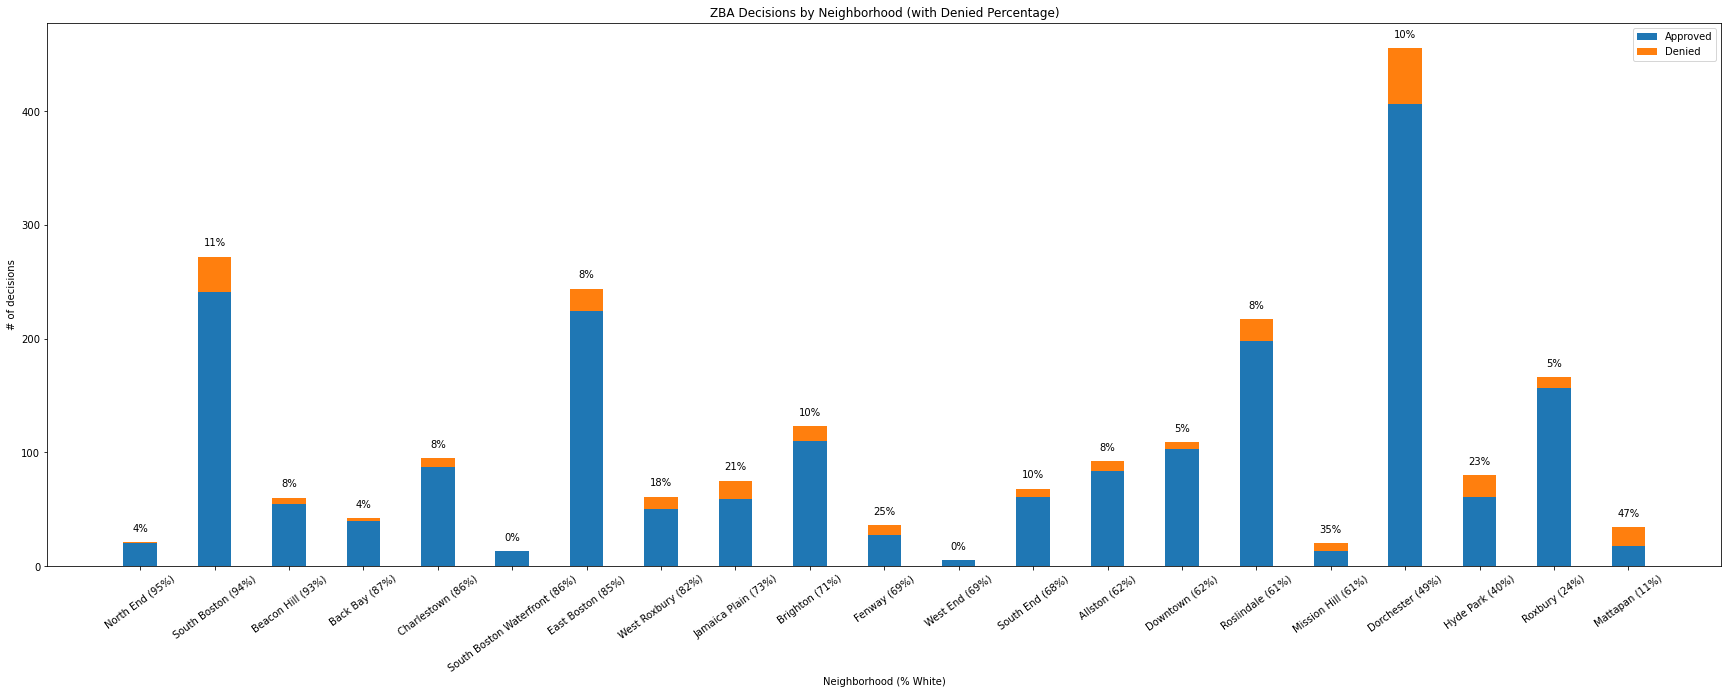

In [131]:
num_approved = grouped_neighs_approved_size.values
num_denied = np.array(grouped_neighs_stats['size'].values) - np.array(grouped_neighs_approved_size.values)
width = 0.45

plt.figure(figsize=[30, 10])
plt.title("ZBA Decisions by Neighborhood (with Denied Percentage)")
plt.xlabel("Neighborhood (% White)")
plt.ylabel("# of decisions")

ind = np.arange(len(grouped_neighs))
p1 = plt.bar(ind, num_approved, width, label="Approved")
p2 = plt.bar(ind, num_denied, width, bottom=num_approved, label="Denied")

plt.legend()
xtix = [grouped_neighs_stats['size'].index[i] + " (" + str(int(grouped_neighs_stats['mean'][i])) + "%)" for i in range(len(grouped_neighs_stats['size'].index))]
plt.xticks(ind, xtix, rotation=36)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for i in range(len(rects)):
        rect = rects[i]
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., grouped_neighs_stats['size'][i] + 8,
                '%d%%' % ((num_denied[i] / (num_denied[i] + num_approved[i])) * 100),
                ha='center', va='bottom')

autolabel(p1)

plt.show()